In [ ]:
import pandas as pd
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
%pip install anndata

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 kB 858.5 kB/s eta 0:00:00


In [ ]:
%pip install scanpy==1.9.8
%pip install cellrank
%pip install scvelo

In [ ]:
import anndata
import scanpy
import cellrank as cr
import scvelo as scv

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
h5ad_path = "path/to/h5ad"
adata = scanpy.read_h5ad(h5ad_path)

In [ ]:
# ANNOTATE THE DONOR1 CELLS
# louvain2type = {
#      0: 'Mature Neutrophil 1',
#      1: 'Immature Neutrophil Day 9',
#      2: 'Immature Neutrophil Day 17',
#      3: 'Mature Neutrophil 2',
#      4: 'Intermediate Neutrophil',
#      5: 'Eosinophil',
#      6: 'GMP/DC',
#      7: 'Erythrocyte',
#      8: 'Monocyte',
#      9: 'Megakaryocytes Progenitor',
#      10: 'Basophil',
#      11: 'Eosinophil Progenitor'
# }

# this is for donor 1
louvain2type = {
     0: 'Mature Neutrophil 2',
     1: 'Mature Neutrophil 3',
     2: 'Mature Neutrophil 1',
     3: 'Immature Neutrophil Day 17',
     4: 'Immature Neutrophil Day 9',
     5: 'Erythrocyte',
     6: 'Eosinophil',
     7: 'GMP',
     8: 'Megakaryocyte',
     9: 'Monocyte 2',
     10: 'Unknown',
     11: 'Monocyte 1'
}

# Convert the Louvain cluster IDs to integers, if they are not already
adata.obs['louvain'] = adata.obs['louvain'].astype(int)

# Map each cell in the Louvain cluster to its corresponding cell type
adata.obs['cell_type'] = adata.obs['louvain'].map(louvain2type)

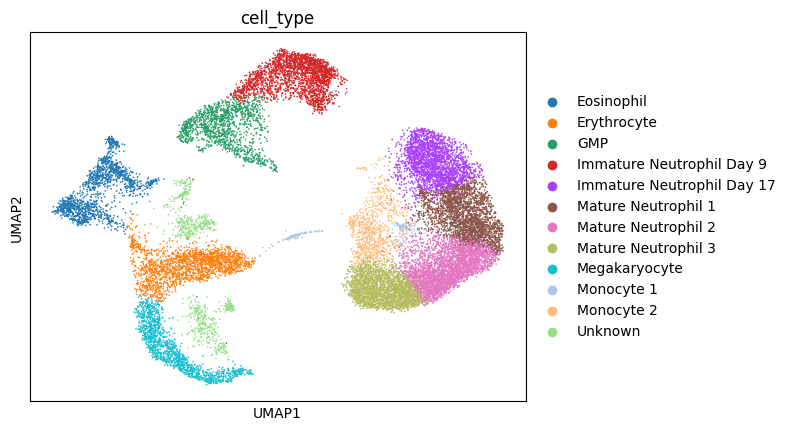

In [ ]:
scanpy.pl.umap(adata, color='cell_type', show=False)
plt.savefig('/content/drive/MyDrive/STAG_Seq_Folder/TNRC18/TNRC18_HSC_STAGseq/figures_donor_1/cell_type_umap.svg', format='svg')

In [ ]:
# donor 2
#new_order = ['9', '7', '6', '11', '5', '10', '1', '2', '4', '0', '3', '8']

# donor 1
new_order = ['8', '5', '7', '6', '4', '3', '2', '0', '1', '9', '11', '10']

adata.obs['louvain'] = adata.obs['louvain'].astype('str') # why I have to do this is beyond me
adata.obs['louvain'] = adata.obs['louvain'].astype('category')
adata.obs['louvain'] = adata.obs['louvain'].cat.reorder_categories(new_order, ordered=True)

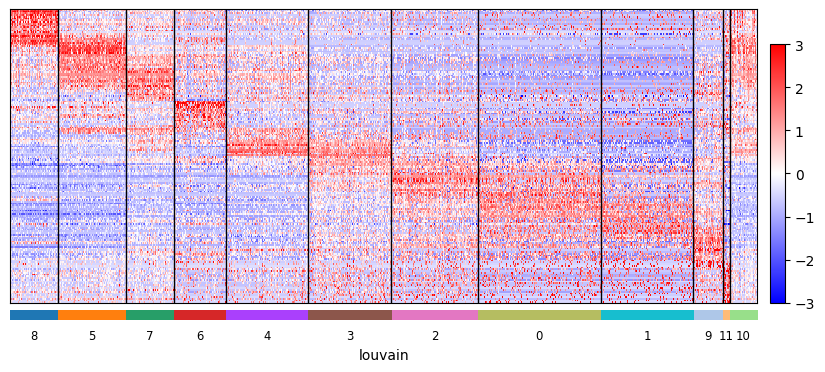

In [ ]:
adata.layers['backup'] = adata.X.copy()
adata.X = np.apply_along_axis(lambda x: (x - np.mean(x)) / np.std(x), 0, adata.X)
scanpy.pl.heatmap(adata, var_names=genes, groupby='louvain', swap_axes=True, cmap='bwr', vmax=3, vmin=-3, show_gene_labels=False, show=False)
plt.savefig('/content/drive/MyDrive/STAG_Seq_Folder/TNRC18/TNRC18_HSC_STAGseq/figures_donor_1/by_cell_heatmap.svg', format='svg')
adata.X = adata.layers['backup']

In [ ]:
import scanpy as sc
import pandas as pd

def differential_expression_per_cell_type(adata):
    cell_types = adata.obs['cell_type'].unique()
    all_genes = set()

    # Initialize a dictionary to store DE results for each cell type
    results = {cell_type: None for cell_type in cell_types}

    for cell_type in cell_types:
        # Subset the data for the current cell type
        cell_type_data = adata[adata.obs['cell_type'] == cell_type]

        # Perform DE analysis between 'XYZ' and 'ref'
        sc.tl.rank_genes_groups(cell_type_data, groupby='mutant_type', reference='AAVS', method='wilcoxon')

        # Extract the results
        de_results = pd.DataFrame({
            'gene': cell_type_data.uns['rank_genes_groups']['names']['chr7:5397122:C/T_hom_pure'],
            'logFC': cell_type_data.uns['rank_genes_groups']['logfoldchanges']['chr7:5397122:C/T_hom_pure'],
            'adj_pvalue': cell_type_data.uns['rank_genes_groups']['pvals_adj']['chr7:5397122:C/T_hom_pure']
        })

        # Add DE results to the dictionary
        results[cell_type] = de_results
        all_genes.update(de_results['gene'])

    # Convert all_genes to a sorted list to maintain consistent order
    all_genes = sorted(all_genes)
    final_results = pd.DataFrame(index=all_genes)

    for cell_type in cell_types:
        # Align and merge results based on the sorted all_genes
        de_results = results[cell_type].set_index('gene').reindex(all_genes)
        final_results[f'{cell_type}_logFC'] = de_results['logFC']
        final_results[f'{cell_type}_adj_pvalue'] = de_results['adj_pvalue']

    return final_results

# Assume adata is your anndata object
final_de_results = differential_expression_per_cell_type(adata)

In [ ]:
final_de_results

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Immature Neutrophil Day 17_logFC,Immature Neutrophil Day 17_adj_pvalue,Eosinophil_logFC,Eosinophil_adj_pvalue,Megakaryocyte_logFC,Megakaryocyte_adj_pvalue,GMP_logFC,GMP_adj_pvalue,Erythrocyte_logFC,Erythrocyte_adj_pvalue,...,Mature Neutrophil 1_logFC,Mature Neutrophil 1_adj_pvalue,Mature Neutrophil 2_logFC,Mature Neutrophil 2_adj_pvalue,Immature Neutrophil Day 9_logFC,Immature Neutrophil Day 9_adj_pvalue,Monocyte 2_logFC,Monocyte 2_adj_pvalue,Mature Neutrophil 3_logFC,Mature Neutrophil 3_adj_pvalue
ABCD3,0.104029,0.997577,-0.260936,0.994264,-0.173290,0.985037,0.137358,0.983768,0.125714,0.996279,...,-0.335676,0.968156,0.233636,0.998155,0.042323,0.998935,0.545023,0.949582,-0.149068,0.999545
ABHD4,0.078706,0.997577,-0.105275,0.994264,0.029220,0.985037,0.417662,0.983768,0.288005,0.996279,...,0.000658,0.984726,0.324279,0.998155,-0.299300,0.998935,-0.420185,0.998006,0.435110,0.999545
ACAA2,-0.401062,0.982562,-0.112932,0.994264,0.181343,0.985037,-0.186235,0.983768,-0.244323,0.996279,...,-0.103848,0.974336,-0.104306,0.998155,0.001664,0.998935,0.184098,0.983860,0.899035,0.999545
ACAT1,0.081860,0.997577,-0.088478,0.994264,0.061751,0.985037,-0.124705,0.983768,0.036300,0.996279,...,-0.859160,0.832572,0.121784,0.998155,-0.137636,0.998935,0.862233,0.951049,-0.853899,0.999545
ACAT2,-0.053680,0.997577,-0.430463,0.994264,-0.107312,0.985037,-0.221594,0.983768,-0.002659,0.996279,...,-0.459462,0.950641,-0.258954,0.998155,-0.343568,0.998935,0.571128,0.974271,-0.584079,0.999545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VCP,-0.189636,0.997577,-0.060537,0.994264,0.092261,0.987306,-0.249066,0.943047,0.061142,0.996279,...,0.132373,0.974336,0.266792,0.998155,-0.220201,0.998935,0.198505,0.983860,0.505334,0.999545
VEGFA,-0.215013,0.997577,-0.245970,0.994264,-0.066995,0.985037,-0.213529,0.983768,-0.301870,0.599668,...,-0.197343,0.974336,-0.548022,0.998155,-0.059868,0.998935,0.683908,0.764571,0.275733,0.999545
VEGFB,-0.395864,0.961360,-0.290905,0.994264,0.066864,0.985037,0.050854,1.000000,-0.095762,0.996279,...,-0.580451,0.968156,-0.283134,0.998155,-0.217282,0.998935,-0.125307,0.992376,1.056648,0.999545
WIPI2,0.003902,0.997577,0.100700,0.994264,0.280258,0.973065,-0.155935,0.983768,-0.036367,0.996279,...,0.125767,0.974430,-0.001422,0.998155,-0.123936,0.998935,0.631744,0.764571,0.689120,0.999545


In [ ]:
domain_genes = ['MMD2',
'RBAK',
'WIPI2',
'SLC29A4',
'TNRC18',
'LINC02983',
'LINC03073',
'FBXL18',
'MIR589',
'ACTB',
'FSCN1',
'RNF216',
'MIR6874']

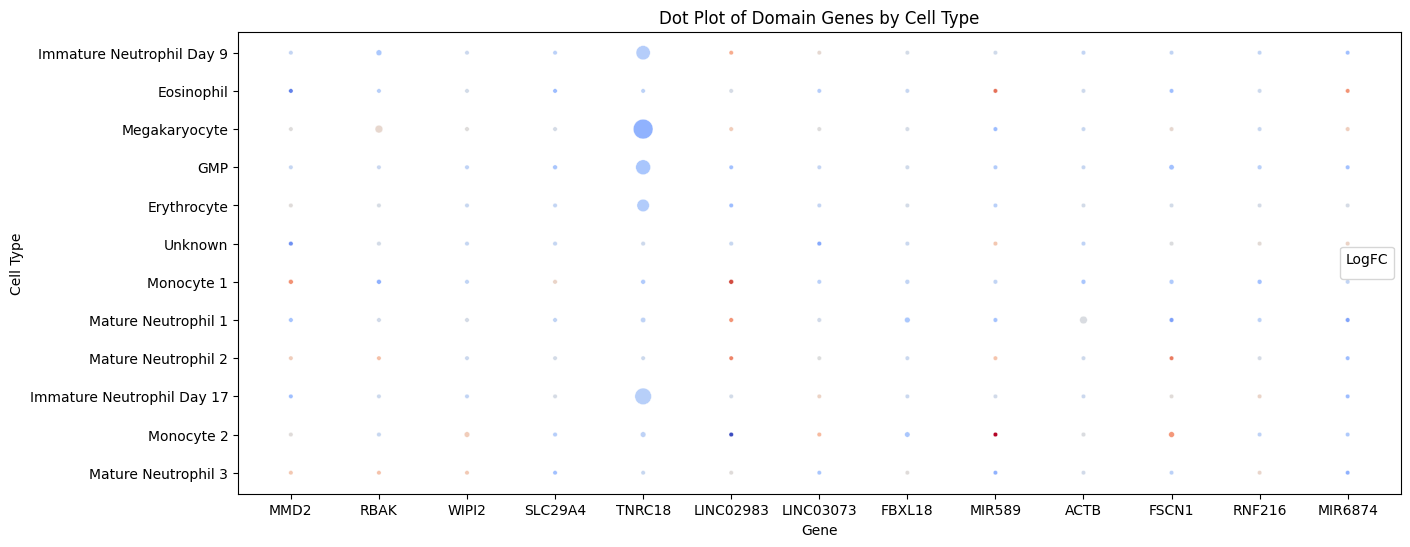

In [ ]:
# Filter final results to include only domain_genes
filtered_results = final_de_results.loc[final_de_results.index.isin(domain_genes)]

# Prepare data for plotting
plot_data = []
for gene in domain_genes:
    gene_data = filtered_results.loc[gene]
    for cell_type in adata.obs['cell_type'].unique():
        logFC_col = f'{cell_type}_logFC'
        adj_pvalue_col = f'{cell_type}_adj_pvalue'
        if logFC_col in gene_data and adj_pvalue_col in gene_data:
            logFC = gene_data[logFC_col]
            adj_pvalue = gene_data[adj_pvalue_col]
            if not pd.isna(logFC) and not pd.isna(adj_pvalue):
                plot_data.append({
                    'gene': gene,
                    'cell_type': cell_type,
                    'logFC': logFC,
                    'adj_pvalue': adj_pvalue,
                    'size': -np.log10(adj_pvalue)  # Transform p-value
                })

plot_df = pd.DataFrame(plot_data)

# Create the dot plot
plt.figure(figsize=(15, 6))
scatter = sns.scatterplot(
    data=plot_df,
    x='gene',
    y='cell_type',
    hue='logFC',
    size='size',
    sizes=(10, 200),
    palette='coolwarm',
    legend=None
)
plt.xlabel('Gene')
plt.ylabel('Cell Type')
plt.title('Dot Plot of Domain Genes by Cell Type')
plt.legend(title='LogFC')
#plt.colorbar(scatter.collections[0], label='logFC')
plt.savefig('/content/drive/MyDrive/STAG_Seq_Folder/TNRC18/TNRC18_HSC_STAGseq/figures_donor_1/domain_dots.svg', format='svg')
plt.show()

In [ ]:
adata_filtered = adata[adata.obs['mutant_type'].isin(['chr7:5397122:C/T_hom_pure', 'chr7:5397122:C/T_het_pure', 'AAVS']), :]
gene_expression = adata_filtered[:, 'TNRC18'].X
data_filtered = adata_filtered.obs[['mutant_type', 'cell_type']]
data_filtered['expression'] = gene_expression.copy().ravel()

In [ ]:
# donor 2
#ordered_cell_types = ['GMP/DC', 'Immature Neutrophil Day 9', 'Immature Neutrophil Day 17', 'Intermediate Neutrophil', 'Mature Neutrophil 1', 'Mature Neutrophil 2']

# donor 1
ordered_cell_types = ['GMP', 'Immature Neutrophil Day 9', 'Immature Neutrophil Day 17', 'Mature Neutrophil 1', 'Mature Neutrophil 2', 'Mature Neutrophil 3']

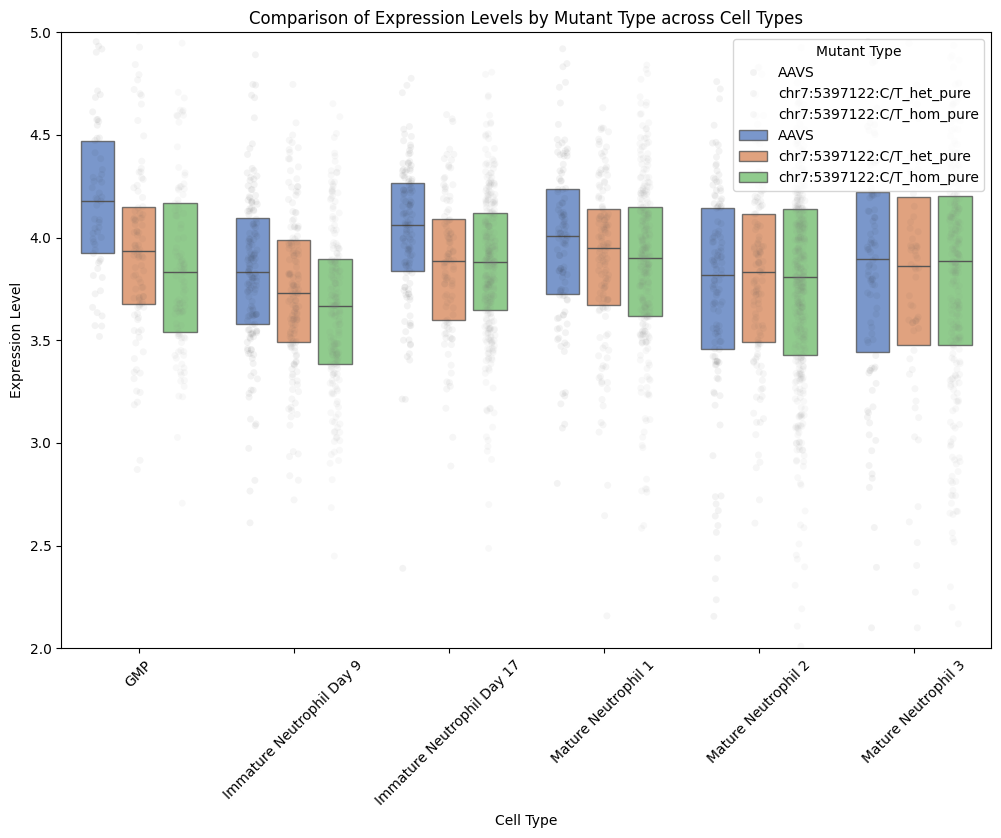

In [ ]:
data_filtered = data_filtered[data_filtered['cell_type'].isin(ordered_cell_types)]
data_filtered['cell_type'] = pd.Categorical(data_filtered['cell_type'], categories=ordered_cell_types, ordered=True)

plt.figure(figsize=(12, 8))

# # Create a box plot with transparent boxes and no whiskers
# box = sns.boxplot(x='cell_type', y='expression', hue='mutant_type', data=data_filtered, palette='muted',
#                   showfliers=False, showcaps=False, whiskerprops={'linewidth': 0}, boxprops={'alpha': 0.5})

# # Overlay swarm plot
# swarm = sns.stripplot(x='cell_type', y='expression', hue='mutant_type', data=data_filtered, color='grey', alpha=0.5, dodge=True, size=5)


swarm = sns.stripplot(x='cell_type', y='expression', hue='mutant_type', data=data_filtered, color='grey', alpha=0.05, dodge=True, size=5)

box = sns.boxplot(x='cell_type', y='expression', gap=0.2, hue='mutant_type', data=data_filtered, palette='muted',
                  showfliers=False, showcaps=False, whiskerprops={'linewidth':0}, fill=True, boxprops={'alpha': 0.8})




# Enhance the plot with titles and labels
plt.title('Comparison of Expression Levels by Mutant Type across Cell Types')
plt.xlabel('Cell Type')
plt.ylabel('Expression Level')
plt.xticks(rotation=45)  # Rotate the x-labels for better readability
plt.ylim(2.0, 5)

# Adjust the legend
plt.legend(title='Mutant Type', loc='upper right')
plt.savefig('/content/drive/MyDrive/STAG_Seq_Folder/TNRC18/TNRC18_HSC_STAGseq/figures_donor_1/box_plots.svg', format='svg')
plt.show()

In [ ]:
if 'spliced' not in adata.layers or 'unspliced' not in adata.layers:
    adata.layers['spliced'] = adata.X
    adata.layers['unspliced'] = adata.X
scv.pp.moments(adata)

ctk = cr.kernels.CytoTRACEKernel(adata)
ckt = ctk.compute_cytotrace()

computing neighbors
    finished (0:00:27) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:10) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


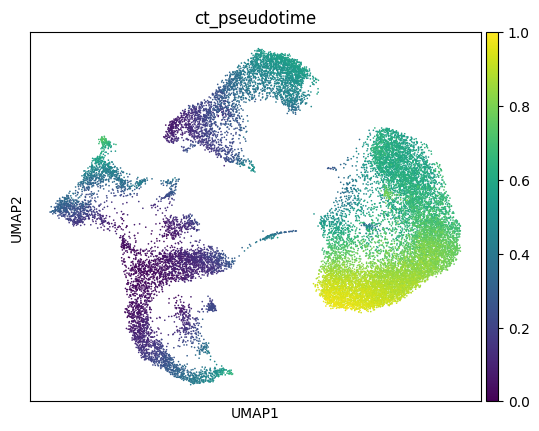

In [ ]:
scanpy.pl.umap(adata, color='ct_pseudotime', show=False)
plt.savefig('/content/drive/MyDrive/STAG_Seq_Folder/TNRC18/TNRC18_HSC_STAGseq/figures_donor_1/cytotrace_umap.svg', format='svg')

In [ ]:
# ordered_cell_types = ['GMP/DC', 'Immature Neutrophil Day 9', 'Immature Neutrophil Day 17', 'Intermediate Neutrophil', 'Mature Neutrophil 1', 'Mature Neutrophil 2']

#mask = adata.obs['cell_type'].isin(['GMP/DC', 'Immature Neutrophil Day 9'])
#mask = adata.obs['cell_type'].isin(['Immature Neutrophil Day 17', 'Intermediate Neutrophil', 'Mature Neutrophil 1', 'Mature Neutrophil 2'])

mask = adata.obs['cell_type'].isin(['GMP', 'Immature Neutrophil Day 9'])
#mask = adata.obs['cell_type'].isin(['Immature Neutrophil Day 17', 'Mature Neutrophil 1', 'Mature Neutrophil 2', 'Mature Neutrophil 3'])

adata_subset = adata[mask].copy()

In [ ]:
if 'TNRC18' in adata_subset.var_names:
    # Extract the data
    data = adata_subset[adata_subset.obs['mutant_type'].isin(['AAVS', 'chr7:5397122:C/T_het_pure', 'chr7:5397122:C/T_hom_pure']), :]
    expression = data[:, 'TNRC18'].X
    # Flatten the array if necessary (depends on the data storage format)
    expression = np.ravel(expression) if expression.ndim > 1 else expression

    # Create a DataFrame
    df = pd.DataFrame({
        'pseudotime': data.obs['ct_pseudotime'],
        'expression': expression,
        'mutant_type': data.obs['mutant_type']
    })
else:
    print("Gene TNRC18 not found in the dataset.")

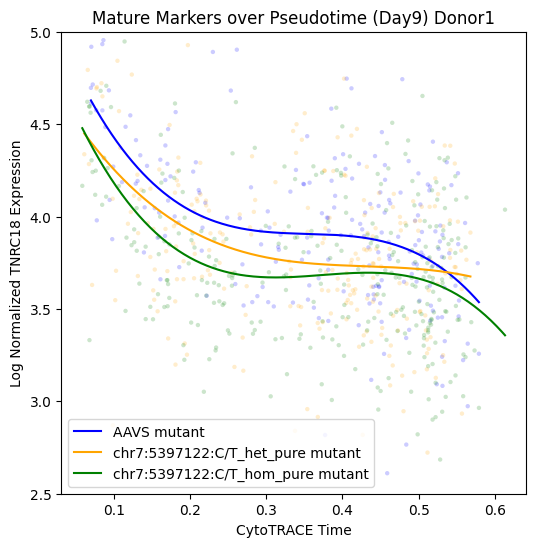

In [ ]:
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

# Plot setup
plt.figure(figsize=(6, 6))

# Colors for the plots
colors = {'AAVS': 'blue', 'chr7:5397122:C/T_het_pure': 'orange', 'chr7:5397122:C/T_hom_pure': 'green'}

# Plot each mutant type
for mtype, color in colors.items():
    subset = df[df['mutant_type'] == mtype]
    # Sort the DataFrame by pseudotime for accurate spline plotting
    subset = subset.sort_values(by='pseudotime')

    # Fit a spline with a smoothing factor; adjust s for your dataset
    spline = UnivariateSpline(subset['pseudotime'], subset['expression'], s=600)
    pseudotime_smooth = np.linspace(subset['pseudotime'].min(), subset['pseudotime'].max(), 300)
    expression_smooth = spline(pseudotime_smooth)

    # Plot
    plt.plot(pseudotime_smooth, expression_smooth, label=f"{mtype} mutant", color=color)
    plt.scatter(subset['pseudotime'], subset['expression'], color=color, alpha=0.2, edgecolor='none', s=10)


plt.title('Mature Markers over Pseudotime (Day9) Donor1')
plt.xlabel('CytoTRACE Time')
plt.ylabel('Log Normalized TNRC18 Expression')
plt.legend()
plt.ylim(2.5, 5)
#plt.xlim(0.3, 1)

plt.savefig('/content/drive/MyDrive/STAG_Seq_Folder/TNRC18/TNRC18_HSC_STAGseq/figures_donor_1/day9.svg', format='svg')  # Save the figure as an SVG file
plt.show()